# 0 Neccesaries

## 0.1 Import Libraries

In [1]:
from IPython.display import display, clear_output
import json

import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression

import seaborn as sns
from keplergl import KeplerGl

## 0.2 Trim Data
kann optional einaml ausgeführt werden um einen Datensatz "trimmed_globalterrorismdb.csv" zu erstellen, welcher auf Github hochgeladen werden kann. Dieser ist jedoch schon im PULL-Umfang enthalten.

Feature: Bad Runtime O(n* n!) -> could be optimized Binary Split

In [2]:
colums_to_use = [
    "eventid",
    "iday",
    "imonth",
    "iyear",
    "longitude",
    "latitude",
    "country",
    "country_txt",
    "nkill",
    "weaptype1",
    "weaptype1_txt",
    "targtype1",
    "targtype1_txt",
    "gname",
    "claimed"
]

max_storage_size = 25*pow(10,6)                                     #max upload size for GitHub

original_df = pd.read_csv("globalterrorismdb.csv", usecols=colums_to_use, low_memory=False)

trimmed_df = pd.DataFrame(columns=colums_to_use)

if original_df.memory_usage().sum() < max_storage_size:
    trimmed_df = original_df

else:
    reversed_df = original_df.iloc[::-1].reset_index(drop=True)     #reverse df to keep the newest entries

    for i, row in original_df.iterrows():
        clear_output(wait=True)
        display(f"{round(i / len(original_df) * 100, 2)} %")

        if trimmed_df.memory_usage().sum() + row.memory_usage() > max_storage_size:
            break                                                   #break if max upload size is reached
        else:
            trimmed_df.loc[i] = row

    trimmed_df = trimmed_df.iloc[::-1].reset_index(drop=True)       #reverse back to original order

print(f"Original File Size: {original_df.memory_usage().sum() / pow(10,6)}")
print(f"Trimmed  File Size: {trimmed_df.memory_usage().sum() / pow(10,6)}")

trimmed_df.to_csv("trimmed_globalterrorismdb.csv")

Original File Size: 21.803052
Trimmed  File Size: 21.803052


# 1 Data Understanding

## 1.1 Read Data

In [3]:
df = pd.read_csv("trimmed_globalterrorismdb.csv", low_memory=False)

## 1.2 Clean Data

In [4]:
#Create datetime colum for further use. Set day to 01.01 if unknown
df["datetime"] = df.apply(lambda x: pd.to_datetime("{}/{}/{}".format(x["iday"] or 1, x["imonth"] or 1, x["iyear"]), dayfirst=True, utc=True), axis=1)

#Shorten "Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)" of row weaptype1_txt to "Vehicle"
df["weaptype1_txt"] = df["weaptype1_txt"].replace("Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)", "Vehicle")

#Create unique int keys for gname
df["gname_txt"] = df["gname"]
df["gname"] = df["gname"].map({value: idx for idx, value in enumerate(df["gname"].unique())})

## 1.3 Analize Data

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   Unnamed: 0     181691 non-null  int64              
 1   eventid        181691 non-null  int64              
 2   iyear          181691 non-null  int64              
 3   imonth         181691 non-null  int64              
 4   iday           181691 non-null  int64              
 5   country        181691 non-null  int64              
 6   country_txt    181691 non-null  object             
 7   latitude       177135 non-null  float64            
 8   longitude      177134 non-null  float64            
 9   targtype1      181691 non-null  int64              
 10  targtype1_txt  181691 non-null  object             
 11  gname          181691 non-null  int64              
 12  claimed        115571 non-null  float64            
 13  weaptype1      181691 non-nul

,Unnamed: 0,eventid,iyear,imonth,iday,country,country_txt,latitude,longitude,targtype1,targtype1_txt,gname,claimed,weaptype1,weaptype1_txt,nkill,datetime,gname_txt
0,0,197000000001,1970,7,2,58,Dominican Republic,18.456792,-69.951164,14,Private Citizens & Property,0,NaN,13,Unknown,1.0,1970-07-02 00:00:00+00:00,MANO-D
1,1,197000000002,1970,0,0,130,Mexico,19.371887,-99.086624,7,Government (Diplomatic),1,NaN,13,Unknown,0.0,1970-01-01 00:00:00+00:00,23rd of September Communist League
2,2,197001000001,1970,1,0,160,Philippines,15.478598,120.599741,10,Journalists & Media,2,NaN,13,Unknown,1.0,1970-01-01 00:00:00+00:00,Unknown
3,3,197001000002,1970,1,0,78,Greece,37.997490,23.762728,7,Government (Diplomatic),2,NaN,6,Explosives,NaN,1970-01-01 00:00:00+00:00,Unknown
4,4,197001000003,1970,1,0,101,Japan,33.580412,130.396361,7,Government (Diplomatic),2,NaN,8,Incendiary,NaN,1970-01-01 00:00:00+00:00,Unknown


# 2 Global Filter and Constants

In [6]:
#Create Filter Switches
apply_all_filter = False                            # <- Change bool to activate all filter
apply_filter_countries = apply_all_filter or True   # <- Change bool to filter countries
apply_filter_years = apply_all_filter or False  	# <- Change bool to filter years
apply_filter_claimed = apply_all_filter or False    # <- Change bool to filter claimed

#Define Filters
filter_countries = [
    #Intresting
    "United States",
    "East Germany (GDR)",
    "West Germany (FRG)",
    "United Kingdom",

    #Amerika
    "Mexico",
    "Nicaragua",
    "Peru",
    "Columbia"

    #Afrika
    "Nigeria",
    "Uganda",
    "Algeria",
    "West Bank and Gaza Strip",

    #Asia
    "Philippines",
    "Sri Lanka",
    "Afghanistan",
    "Bangladesh"
]
filter_years = list(range(1970, 2001))
filter_claimed = [1, 1.0, True]

#Apply Filters
if apply_filter_countries:
    df = df[df["country_txt"].isin(filter_countries)]
if apply_filter_years:
    df = df[df["iyear"].isin(filter_years)]
if apply_filter_claimed:
    df = df[df["claimed"].isin(filter_claimed)]

#Define u for top u / bottom u analysis
u = 10
top_u_countries = df["country_txt"].value_counts().head(u).sort_values(ascending=False).index.tolist()
bottom_u_countries = df["country_txt"].value_counts().tail(u).sort_values().index.tolist()

# 3 Auswertung

## 3.1 Charts

### 3.1.1 Bar Chart - Top / Bottom u Countries

In [7]:
df_top_u_countries = df["country_txt"].value_counts().head(u).iloc[::-1]
df_bottom_u_countries = df["country_txt"].value_counts().tail(u)

fig = make_subplots(rows=1, cols=2, subplot_titles=(f"Top {u} Countries", "Bottom 10"), horizontal_spacing=0.3)

fig.add_trace(
    go.Bar(
        x=df_top_u_countries.values,
        y=df_top_u_countries.index,
        orientation='h',
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        x=df_bottom_u_countries.values,
        y=df_bottom_u_countries.index,
        orientation='h'
    ),
    row=1, col=2
)
fig.update_layout(
    height=400, 
    width=1000,
    showlegend=False
)
fig.show()

### 3.1.2 Pie Chart - Weapons

In [8]:
df_weaptype_count = df.groupby(["weaptype1_txt"]).size().reset_index(name="count")
df_year_count = df.groupby(["iyear"]).size().reset_index(name="count")

fig = make_subplots(rows=1, cols=2, subplot_titles=("Years", "Weapons"), horizontal_spacing=0, specs=[[{'type':'violin'}, {'type':'pie'}]])
fig.append_trace(
    px.violin(
        df_year_count,
        y="iyear",
        box=True,
        points="all"
    ).data[0],
    row=1, col=1
)
fig.append_trace(
    px.pie(
        df_weaptype_count,
        values="count",
        labels="weaptype1_txt",
        names="weaptype1_txt"
    ).update_traces(
        textposition='inside'
    ).update_layout(
        uniformtext_minsize=12, uniformtext_mode='hide', showlegend=True
    ).data[0],
    row=1, col=2
)

fig.show()

### 3.1.1 Line Chart - Visulize History by Country / Weapon

In [9]:
df_year_country_count = df.groupby(["iyear", "country_txt"]).size().reset_index(name='count')
df_year_weaptype_count = df.groupby(["iyear", "weaptype1_txt"]).size().reset_index(name="count")

df_year_count = df.groupby(["iyear"]).size().reset_index(name="sum")


reg_year_sum = LinearRegression().fit(
    np.array(df_year_count["iyear"]).reshape(-1, 1),
    np.array(df_year_count["sum"]).reshape(-1, 1)
)
reg_x = np.array(df_year_country_count["iyear"]).reshape(-1, 1)
reg_y = reg_year_sum.predict(np.array(df_year_country_count["iyear"]).reshape(-1, 1))


px.area(
    df_year_country_count, x="iyear", y="count", color="country_txt", title="Countries"
).add_trace(
    px.line(x=reg_x[:,0], y=reg_y[:,0]).data[0]
).show()

px.area(
    df_year_weaptype_count, x="iyear", y="count", color="weaptype1_txt", title="Weapons"
).add_trace(
    px.line(x=reg_x[:,0], y=reg_y[:,0]).data[0]
).show()

## 3.2 Correlation

### 3.2.1 2D Correlation Table

<Axes: >

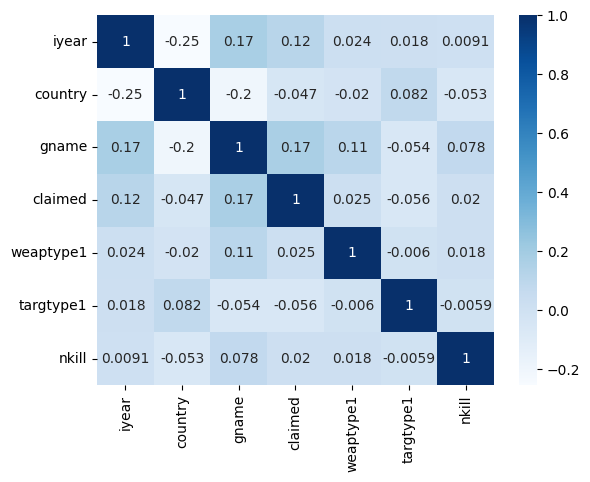

In [10]:
df_correlation = df.loc[:, ["iyear", "country", "gname", "claimed", "weaptype1", "targtype1", "nkill"]]
df_correlation.dropna(inplace=True)

sns.heatmap(df_correlation.corr(), cmap="Blues", annot=True)

### 3.2.2 3D Visual Cluster

In [11]:
px.scatter_3d(
    df,
    x="country_txt",
    y="gname_txt",
    z="targtype1_txt",
    color="gname_txt",
    symbol="claimed",
    animation_frame="iyear",
    title="Terrorist Incidents Clustering",
    labels={"country_txt": "Country", "gname_txt": "Group", "targtype1_txt" : "Target"},
    opacity=0.7,
).update_layout(
    scene=dict(
        xaxis_title="Country",
        yaxis_title="Group",
        zaxis_title="Target",
    ),
    showlegend=False,
    width=700, height=700,
).show()

## 3.3 Trend

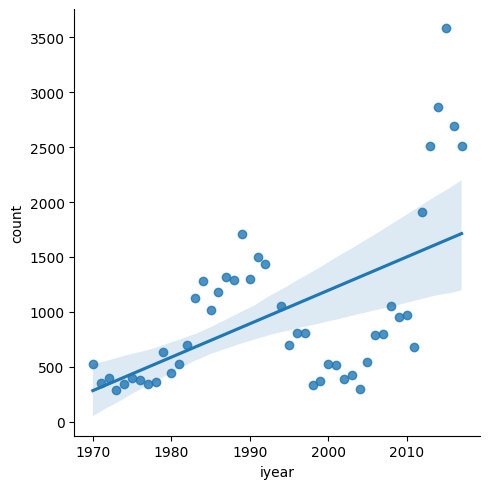

In [12]:
df_year_counts = df.groupby("iyear").size().reset_index(name="count")

sns.lmplot(x="iyear", y="count", data=df_year_counts)

## 3.4 Geo-Mapping
Visulize Attacks based on coordinates with corresponding fatalities and weapons

In [15]:
df_nkills_weaptype = df
df_nkills_weaptype.dropna(subset=["longitude", "latitude"], inplace=True)
df_nkills_weaptype["height"] = (df_nkills_weaptype["nkill"].fillna(0) + 1) * 100 #scale can be adjusted
df_nkills_weaptype["weaptype1_txt"] = df_nkills_weaptype["weaptype1_txt"].fillna("Unknown")

map_nkills_weaptype = KeplerGl()
map_nkills_weaptype.add_data(data=df_nkills_weaptype, name="df_nkills_weaptype1")

map_nkills_weaptype.config = json.loads(
    """
        {
            "version": "v1",
            "config": {
                "visState": {
                    "filters": [],
                    "layers": [
                        {
                            "id": "9dw62hh",
                            "type": "grid",
                            "config": {
                                "dataId": "df_nkills_weaptype1",
                                "label": "grid_nkills_weaptype1",
                                "color": [
                                    137,
                                    218,
                                    193
                                ],
                                "highlightColor": [
                                    252,
                                    242,
                                    26,
                                    255
                                ],
                                "columns": {
                                    "lat": "latitude",
                                    "lng": "longitude"
                                },
                                "isVisible": true,
                                "visConfig": {
                                    "opacity": 1,
                                    "worldUnitSize": 20,
                                    "colorRange": {
                                        "name": "Global Warming",
                                        "type": "sequential",
                                        "category": "Uber",
                                        "colors": [
                                            "#e6194b",
                                            "#3cb44b",
                                            "#ffe119",
                                            "#4363d8",
                                            "#f58231",
                                            "#911eb4",
                                            "#46f0f0",
                                            "#f032e6",
                                            "#bcf60c",
                                            "#fabebe",
                                            "#008080",
                                            "#e6beff",
                                            "#9a6324",
                                            "#fffac8",
                                            "#800000",
                                            "#aaffc3",
                                            "#808000",
                                            "#ffd8b1",
                                            "#000075",
                                            "#808080",
                                            "#ffffff",
                                            "#000000"
                                        ],
                                        "reversed": true
                                    },
                                    "coverage": 1,
                                    "sizeRange": [
                                        0,
                                        500
                                    ],
                                    "percentile": [
                                        0,
                                        100
                                    ],
                                    "elevationPercentile": [
                                        0,
                                        100
                                    ],
                                    "elevationScale": 50,
                                    "enableElevationZoomFactor": true,
                                    "colorAggregation": "mode",
                                    "sizeAggregation": "average",
                                    "enable3d": true
                                },
                                "hidden": false,
                                "textLabel": [
                                    {
                                        "field": null,
                                        "color": [
                                            255,
                                            255,
                                            255
                                        ],
                                        "size": 18,
                                        "offset": [
                                            0,
                                            0
                                        ],
                                        "anchor": "start",
                                        "alignment": "center"
                                    }
                                ]
                            },
                            "visualChannels": {
                                "colorField": {
                                    "name": "weaptype1_txt",
                                    "type": "string"
                                },
                                "colorScale": "ordinal",
                                "sizeField": {
                                    "name": "height",
                                    "type": "integer"
                                },
                                "sizeScale": "linear"
                            }
                        }
                    ],
                    "interactionConfig": {
                        "tooltip": {
                            "fieldsToShow": {
                                "df_nkills_weaptype1": [
                                    {
                                        "name": "eventid",
                                        "format": null
                                    },
                                    {
                                        "name": "datetime",
                                        "format": null
                                    },
                                    {
                                        "name": "nkill",
                                        "format": null
                                    },
                                    {
                                        "name": "height",
                                        "format": null
                                    },
                                    {
                                        "name": "weaptype1",
                                        "format": null
                                    }
                                ]
                            },
                            "compareMode": false,
                            "compareType": "absolute",
                            "enabled": true
                        },
                        "brush": {
                            "size": 0.5,
                            "enabled": false
                        },
                        "geocoder": {
                            "enabled": false
                        },
                        "coordinate": {
                            "enabled": false
                        }
                    },
                    "layerBlending": "normal",
                    "splitMaps": [],
                    "animationConfig": {
                        "currentTime": null,
                        "speed": 1
                    }
                },
                "mapState": {
                    "bearing": 24,
                    "dragRotate": true,
                    "latitude": 46.392431227148506,
                    "longitude": 10.866975876510729,
                    "pitch": 50,
                    "zoom": 6.072544957076989,
                    "isSplit": false
                },
                "mapStyle": {
                    "styleType": "dark",
                    "topLayerGroups": {
                        "land": true,
                        "water": false,
                        "building": true,
                        "road": true,
                        "label": true
                    },
                    "visibleLayerGroups": {
                        "label": false,
                        "road": true,
                        "border": true,
                        "building": true,
                        "water": true,
                        "land": true,
                        "3d building": false
                    },
                    "threeDBuildingColor": [
                        9.665468314072013,
                        17.18305478057247,
                        31.1442867897876
                    ],
                    "mapStyles": {}
                }
            }
        }

    """
)

map_nkills_weaptype

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\ZODWEISS\AppData\Roaming\Python\Python311\site-packages\jupyter_client\session.py:721: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '9dw62hh', 'type': …

In [14]:
#print(json.dumps(map_nkills_weaptype.config, indent=4))